# A hands-on intro to GP regression

**Dan Foreman-Mackey** (foreman.mackey@gmail.com)

In this tutorial, we'll work through an example problem in Gaussian process (GP) regression using Python.
The goal of the tutorial is to give you a qualitative sense of how GP regression works and a rough idea of how you might implement it in a real world problem.

This is designed to be open-ended and the last sections should be instructive even if you're already familiar with the implementation of GPs.
I've chosen to use Python because it is my programming language of choice and because it is commonly used in astronomy, but if you don't have experience coding in Python I've tried to include a lot of skeleton code so you should still be able to make progress without getting too caught up with Python's syntax.
Also, if you ever find yourself writing a `for` loop then something is wrong; Python is an interpreted language and, as a result, looping is *very* slow.
This entire worksheet can be done without looping.

*Remember*: The best reference for all things GPs is [Rasmussen & Williams](http://www.gaussianprocess.org/gpml/).

## Getting started

First let's set up this notebook by importing everything we'll need and choose some settings so that the plots look better:

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

# Start by importing the specific code for this project.
import gp

# And then the standard numerical Python modules.
import emcee
import numpy as np
import matplotlib.pyplot as plt

# Finally set up the plotting to look a little nicer.
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

## 1 – Fitting a "transit" with "correlated noise"

In this section, we'll work through how to fit a simplified transit model to data in the presence of "correlated noise".
I think that it's important to clarify what I mean by "noise" here because it isn't necessarily what you immediately expect.
When I say noise, I'm referring to *everything that contributes to generating the data that isn't an exoplanet transit*.
In the context of transit fitting, this means that everything that the spacecraft is doing (pointing and temperature variations, etc.) and everything that the star is doing (rotation, asteroseismic oscillations, granulation, etc.) is "noise".
As you can imagine, in many cases this noise might actually be the thing that you're trying to measure and that's fine – I spend most of my time measuring noise!
Therefore, more formally, "noise model" refers to anything that we're modeling as **stochastic** and the "mean model" refers to anything that we're modeling as **deterministic**.
For the purposes of this tutorial, we're not going to interpret the stochastic component of the signal and, instead, focus on studying the mean model, but that is not a limitation of GP modeling in general.

### 1.1 – The "mean model"

In this tutorial, we'll be fitting a very simple "transit" model with three parameters (depth, duration, and transit time) to a simulated dataset.
This model is implemented in the `gp` module that was included with this notebook and here's an example of how it works:

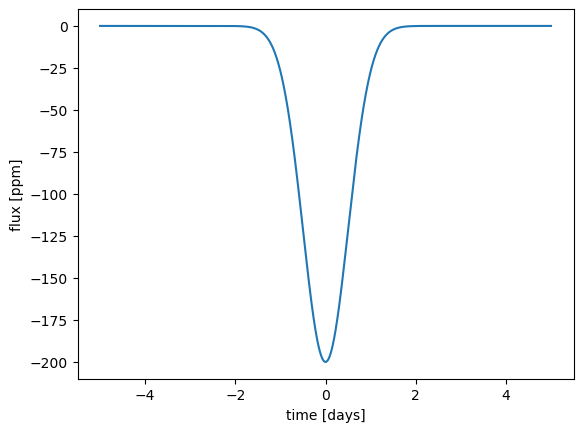

In [2]:
t = np.linspace(-5, 5, 5000)
model = gp.SillyTransitModel(log_depth=np.log(200.0), log_duration=np.log(0.5), time=0.0)
plt.plot(t, model.get_value(t))
plt.xlabel("time [days]")
plt.ylabel("flux [ppm]");

This obviously isn't meant to be realistic, but it's a good enough toy problem for today.
This model has a few nice features that might come in handy later:

In [3]:
print("parameter_dict:")
print(model.get_parameter_dict())

print("\nparameter_vector:")
print(model.get_parameter_vector())

print("\nyou can freeze and thaw parameters...")
print("the depth, for example, is now fixed to the current value:")
model.freeze_parameter("log_depth")
print(model.get_parameter_dict())

print("\nand 'thawed':")
model.thaw_parameter("log_depth")
print(model.get_parameter_dict())

parameter_dict:
OrderedDict([('log_depth', 5.298317366548036), ('log_duration', -0.6931471805599453), ('time', 0.0)])

parameter_vector:
[ 5.29831737 -0.69314718  0.        ]

you can freeze and thaw parameters...
the depth, for example, is now fixed to the current value:
OrderedDict([('log_duration', -0.6931471805599453), ('time', 0.0)])

and 'thawed':
OrderedDict([('log_depth', 5.298317366548036), ('log_duration', -0.6931471805599453), ('time', 0.0)])


### 1.2 – Fitting the usual way

I've included some code to simulate a dataset with a "transit" given by our silly model.
Here's how you get it and plot it:

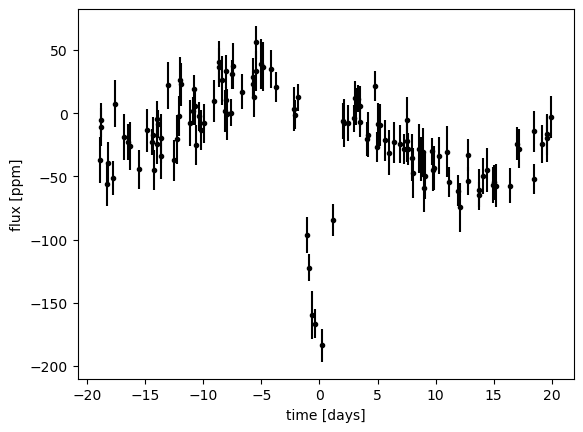

In [4]:
t, y, yerr = gp.data.generate_dataset()
plt.errorbar(t, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("flux [ppm]");

It should be clear that there's some white noise (the error bars show that part) but that something else is going on.
There should be some sort of "trend" on top of which the transit is superimposed.
This might have been caused by spots rotating into and out of view, motion of the spacecraft, or something else.
As I mentioned at the top, we won't worry too much about interpreting these trends.

Now, let's start by fitting this data the usual way: ignoring the correlated noise.
(I recognize that I'm being a bit unfair here and point out that most transit fitting results also fit out some parametric form for the trend, but this demo gets today's point across so bear with me...)

The usual likelihood function that we can derive assuming independent Gaussian noise is:

$$
\ln p(\mathrm{data}\,|\,\mathrm{model}) = -\frac{1}{2}\sum_{n=1}^N\left[\frac{[y_n - m(t_n)]^2}{{\sigma_n}^2} + \ln(2\,\pi\,{\sigma_n}^2)\right ] = -\frac{1}{2}\,\chi^2 + \mathrm{constant}
$$

where $m(t)$ is the transit model and we might maximize this (or, equivalently, minimize $\chi^2$) to find the "best-fit" parameters.
Instead, we'll apply improper uniform priors (*Disclaimer: don't think that I condone this behavior*) and sample the posterior probability density for the parameters of the model using [emcee](http://dan.iel.fm/emcee).

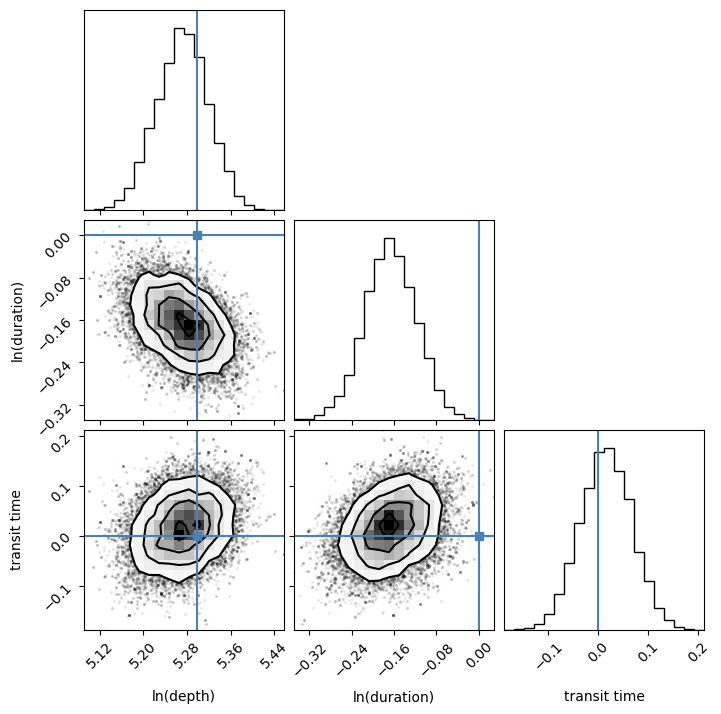

In [5]:
def simple_log_prob(params, model, t, y, yerr):
    model.set_parameter_vector(params)
    resid = y - model.get_value(t)
    return -0.5 * np.sum((resid/yerr)**2)

ndim = 3
nwalkers = 16
pos = 1e-4*np.random.randn(nwalkers, ndim)
pos[:, 0] += 5
sampler = emcee.EnsembleSampler(nwalkers, ndim, simple_log_prob,
                                args=(model, t, y, yerr))
pos, _, _ = sampler.run_mcmc(pos, 200)
sampler.reset()
sampler.run_mcmc(pos, 2000);

gp.corner(sampler.flatchain, truths=gp.data.true_parameters,
          labels=["ln(depth)", "ln(duration)", "transit time"]);

In this figure, you should see the posterior constraints on the parameters compared to the true values that were used to simulate the data shown as blue lines.
If everything went as planned, this should be your feeling about the result:

<div style="font-size:200%;padding:20px 0 0">😕</div>

This didn't work because we ignored the correlated noise!
And this brings us to...

### 1.3 – Building a Gaussian process model

Now let’s implement the code for a Gaussian process.
The main thing that you need to do in this section is write the ln-likelihood function.
What you need to do is convert the following mathematical equation (you might remember it from earlier) to Python:

$$
\ln p(\mathrm{data}\,|\,\mathrm{model}) = \ln L = -\frac{1}{2}\,\boldsymbol{r}^\mathrm{T}\,K^{-1}\,\boldsymbol{r} - \frac{1}{2}\,\ln \det \boldsymbol{K} - C
$$

where $C = N\,\ln(2\,\pi)/2$ is an irrelevant (for our purposes) constant, $\boldsymbol{r}$ is the residual vector (the difference between the measured $y$ and the model predictions for $y$), and $K$ is the covariance matrix describing the measurement uncertainties and the correlations between observations.

In the following cell, you'll implement a Python function that takes as input a residual vector `r` and a covariance matrix `K` and returns the right-hand side of the above equation.
In pseudocode, the function will look something like:

<hr>

**Input:** Residual vector $\boldsymbol{r}$; covariance matrix $K$<br>
**Output:** The ln-likelihood (up to a constant)
1. $\boldsymbol{\alpha} = \mathtt{np.linalg.solve}({K},\,\boldsymbol{r})$
2. $(s,\,d) = \mathtt{np.linalg.slogdet}(\boldsymbol{K})$
3. **return** $-0.5\,\left(\boldsymbol{r}\cdot\boldsymbol{\alpha} + d\right)$

<hr>

When implementing this function, the two numpy (remember that we imported `numpy` as `np` above) methods used in the pseudocode ([`np.linalg.solve`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) and [`np.linalg.slogdet`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html)) will come in handy.
The `solve` method is useful because you should *never* invert a matrix (it is numerically unstable).
Instead, you should always use `solve` if you want to find $\boldsymbol{x}$ in the equation:

$$
\boldsymbol{x} = {K}^{-1}\,\boldsymbol{r} \to \boldsymbol{r} = {K}\,\boldsymbol{x} \quad.
$$

The `slogdet` function is useful because it computes the ln-determinant of a matrix using a numerically stable method.
Determinants of physical matrices tend to be *very* tiny and computing them naively can result in numerical underflow.
Sticking to the ln-determinant will make you less suceptible to this problem.

Finally, if you want to take the dot product of two vectors or matrices, you should use the [`np.dot`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) function.

(*If you're already an expert, you can actually speed this code up substantially using the [cho_factor](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.linalg.cho_factor.html) and [cho_solve](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.linalg.cho_solve.html) functions from scipy and figuring out how to compute the determinant of a matrix using its [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition). Follow the links to documentation for `cho_factor` to see what, exactly, it returns. You can extract the diagonal elements from a matrix using the [`np.diag`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html) function.
Other functions you may want to use include `np.sum` and `np.log`.*) 

OK. Go for it! Bonus points if your implementation fits in a Tweet (don't forget to include the #KeplerSciCon hashtag).

In [49]:
def log_like(r, K):
    """
    The multivariate Gaussian ln-likelihood (up to a constant) for the
    vector ``r`` given a covariance matrix ``K``.
    
    :param r: ``(N,)``   The residual vector with ``N`` points.
    :param K: ``(N, N)`` The square (``N x N``) covariance matrix.
    
    :returns lnlike: ``float`` The Gaussian ln-likelihood. 
    
    """
    # Erase the following line and implement the Gaussian process
    # ln-likelihood here.
    import math 
    a = np.linalg.solve(K, r)
    s, d = np.linalg.slogdet(K)
    return -.5 * (r.dot(a) + d)

When you're happy with your implementation, execute the following cell.
If your implementation is correct, you'll see a smiley face (☺︎) otherwise, it will throw an exception.

In [50]:
gp.utils.test_log_like(log_like)

☺︎


Did you see a happy face when you executed the above line?
Edit your `log_like` function until you do and then let's move on to implementing a specific model.

### 1.4 – The covariance matrix/kernel function

Now that we have the likelihood function implemented, we need to choose a specific model of the covariance matrix $K$.
Each element of the matrix $K_{ij}$, will be given by

$$
K_{ij} = k_{\boldsymbol{\alpha}}(x_i,\,x_j)
$$

where we get to choose the "kernel function" $k_{\boldsymbol{\alpha}}$ (parameterized by ${\boldsymbol{\alpha}}$).
For now, let's implement the *exponential-squared kernel*:

$$
k_{\boldsymbol{\alpha}}(r_{ij}) = a^2 \, \exp \left ( -\frac{{\Delta x_{ij}}^2}{2\,l^2} \right )
$$

where $\boldsymbol{\alpha} = (a,\,l)$ and $\Delta x_{ij} = |x_i - x_j|$.

You need to implement this function below and it needs to work with a `numpy` array `dx` as input (use the `np.exp` function for exponentiation).
Note that `alpha` will be a list with two elements: `alpha[0] = amp` and `alpha[1] = ell`; Python arrays are zero-indexed.

In [61]:
def expsq_kernel(alpha, dx):
    """
    The exponential-squared kernel function. The difference matrix
    can be an arbitrarily shaped numpy array so make sure that you
    use functions like ``numpy.exp`` for exponentiation.
    
    :param alpha: ``(2,)`` The parameter vector ``(amp, ell)``.
    :param dx: ``numpy.array`` The difference matrix. This can be
        a numpy array with arbitrary shape.
    
    :returns K: The kernel matrix (should be the same shape as the
        input ``dx``). 
    
    """
    a = alpha[0]
    a2 = a ** 2
    ell = alpha[1]
    l2 = ell ** 2
    return a2 * np.exp( -1 * ( (np.abs(dx) ** 2)/(2 * l2)))

Once you're happy with your implementation of `expsq_kernel`, try executing the following cell to test your code.
Again, if you've implemented it correctly, you'll see a smiley face.

In [62]:
gp.utils.test_kernel(expsq_kernel)

☺︎


### 1.5 – Qualitative effects of kernel (hyper)parameters

Now that we've implemented our kernel function, let's try to get a qualitative sense of what the hyperparameters do.

**Note:** *another good resource for trying this out is [gp.js](http://dan.iel.fm/gp.js/)*.

To start, we'll generate samples from the likelihood function that we implemented.
Remember that a likelihood is a probability distribution over *data* so, conditioned on specific hyperparameters, we can sample synthetic datasets from the likelihood.
For a Gaussian process, this probability function is a multivariate Gaussian where the covariance matrix is given by our kernel function.

In the following cell, we're using some IPython magic to create an interactive figure that displays 6 samples $\boldsymbol{y}_k$ from the likelihood for variable values of the hyperparameters.
Try executing the cell and then moving the sliders to get a feel for how the samples change with $a$ (`amp`) and $l$ (`ell`).

In [ ]:
gp.interactive.setup_likelihood_sampler(expsq_kernel)

The conditional distribution is even more interesting.
That is, given the data that you have observed and a specific set of parameters, what is your prediction at other points $\boldsymbol{x}_\star$?
The math can be found in Chapter 2 of [R&W](http://www.gaussianprocess.org/gpml/), you can just execute the following cell and play around with the parameters to see how the predictions change with all the parameter choices.

In the figure, the "noiseless" transit function is shown as a dotted red line and the 6 samples from the conditional distribution are shown as black lines.
The ln-likelihood is shown in the title of the figure.
We'll use the results of your experiments to initialize the MCMC sampler in a bit so try to get a good fit.

In [ ]:
widget = gp.interactive.setup_conditional_sampler(t, y, yerr, expsq_kernel)
widget

Once you've found an initial guess that you're happy with, let's run some MCMC and see what our results look like.
In this fit, we're going to sample for the parameters of the transit and the parameters of the GP (these ones are often called "hyperparameters") simultaneously.
This means that any constraints that we get on the transit parameters will have the uncertainty in the noise model taken into account.
Be warned, this MCMC will take a little longer to run than the last one because the GP model is a little bit more expensive to compute (we'll come back to this later).

In [ ]:
def gp_log_prob(params, log_like_fn, kernel_fn, mean_model, t, y, yerr):
    if np.any(params < -10.) or np.any(params > 10.):
        return -np.inf
    
    k = mean_model.vector_size
    
    # Compute the covariance matrix
    K = kernel_fn(np.exp(params[k:]), t[:, None] - t[None, :])
    K[np.diag_indices_from(K)] += yerr**2
    
    # Compute the residual vector
    mean_model.set_parameter_vector(params[:k])
    resid = y - model.get_value(t)
    
    # Compute the log likelihood
    return log_like_fn(resid, K)

ndim = 5
nwalkers = 16
pos = [np.log(np.abs(widget.kwargs[k])) for k in ["depth", "duration", "amp", "ell"]]
pos = np.array(pos[:2] + [widget.kwargs["time"]] + pos[2:]) 
pos = pos + 1e-4*np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, gp_log_prob,
                                args=(log_like, expsq_kernel, model, t, y, yerr))
pos, _, _ = sampler.run_mcmc(pos, 200)
sampler.reset()
sampler.run_mcmc(pos, 2000);

gp.corner(sampler.flatchain, truths=np.append(gp.data.true_parameters, [None, None]),
          labels=["ln(depth)", "ln(duration)", "transit time", "ln(amp)", "ln(ell)"])

If everything went as planned, you should have found a much more acceptable constraint on the parameters.
You'll notice that the GP parameter panels don't have blue lines on them.
This is because we don't know the "true" noise model; we're only using the GP as an *effective* model.

## 2 – Using GPs in Python

In the previous section, we developed a fully-functional GP code that you could now use for research, but it might be better to use an existing software package that makes it easier to try out different models and some other niceties.
There are packages in every programming language but, if you use Python as your programming language of choice, there are a few different software packages that you can use.
Here are a few options:

1. [george](http://dan.iel.fm/george) – Written (by me!) with astronomy in mind. Good for general purpose GP modeling.
2. [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html) – Well supported package with a big community. Can be used for astronomy projects with some work.
3. [GPy](https://github.com/SheffieldML/GPy) – Very flexible with state-of-the-art inference algorithms designed by machine learning researchers.
4. [PyMC](https://pymc-devs.github.io/pymc3/notebooks/GP-introduction.html) – Implementation in the context of Hamiltonian MCMC sampling.
5. [Stan](http://mc-stan.org/) – Like PyMC, a Hamiltonian MCMC sampler with GP support.
6. [celerite](http://celerite.readthedocs.io/) – Scalable GP likelihood calculations for 1D datasets (e.g. time series).
7. etc. – I'm sure that there are others that I've missed!

## 3 – Choosing a kernel

Earlier in this tutorial, we chose to use the exponential-squared kernel function for the experiements.
This was a good idea because it is *exactly* the kernel that I used to generate the data.
That being said, in The Real World™, we never know what kernel to use and there are some other commonly used functions.
One good simple example is the Matern-3/2 function

$$
k_{\boldsymbol{\alpha}}(r_{ij}) = a^2 \, \left[1+\frac{\sqrt{3}\,|\Delta x_{ij}|}{l}\right]\, \exp \left ( -\frac{\sqrt{3}\,|\Delta x_{ij}|}{l} \right )
$$

Try implementing this function (or another one of your choice; see [Chapter 4](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) of [R&W](http://www.gaussianprocess.org/gpml/) for examples) and re-run the analysis with this kernel.
There is no included unit test for this kernel (since this is an optional extension) bu‘t you might consider making some plots or writing your own tests to make sure that the function returns sensible values.

In [ ]:
def matern32_kernel(alpha, dx):
    """
    The Mater-3/2 kernel function. The difference matrix
    can be an arbitrarily shaped numpy array so make sure that you
    use functions like ``numpy.exp`` for exponentiation.
    
    :param alpha: ``(2,)`` The parameter vector ``(amp, ell)``.
    :param dx: ``numpy.array`` The difference matrix. This can be
        a numpy array with arbitrary shape.
    
    :returns K: The kernel matrix (should be the same shape as the
        input ``dx``). 
    
    """
    # Erase the following line and implement your kernel function
    # there.
    pass

Take a look at the conditional distribution given by this new choice of kernel:

In [ ]:
widget = gp.interactive.setup_conditional_sampler(t, y, yerr, matern32_kernel)
widget

Try running the MCMC sampling with this kernel:

In [ ]:
pos = [np.log(np.abs(widget.kwargs[k])) for k in ["depth", "duration", "amp", "ell"]]
pos = np.array(pos[:2] + [widget.kwargs["time"]] + pos[2:]) 
pos = pos + 1e-4*np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, gp_log_prob,
                                args=(log_like, matern32_kernel, model, t, y, yerr))
pos, _, _ = sampler.run_mcmc(pos, 200)
sampler.reset()
sampler.run_mcmc(pos, 2000);

gp.corner(sampler.flatchain, truths=np.append(gp.data.true_parameters, [None, None]),
          labels=["ln(depth)", "ln(duration)", "transit time", "ln(amp)", "ln(ell)"])

Depending on the specific choices that you made, this may or may not look awesome.
If not, try to debug the code (and make sure that you choose a good initial guess) until it does or, otherwise, come up with an argument for what is happening.

As a general guideline, the choice of kernel often won't significantly affect your inferences about the parameters of the mean model.
That being said, if you don't have a physical motivation for your kernel choice, it's useful to try some sort of formal model comparison.
There is nothing special about kernel selection compared to other model selection problems so the usual techniques ([Bayes factors](https://en.wikipedia.org/wiki/Bayes_factor), [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29), [information criteria](https://en.wikipedia.org/wiki/Bayesian_information_criterion), etc.) are all applicable.

## 4 – Advanced: Outliers

If you've ever tried to fit a model to real data, I'm sure that you've run into issues with outliers.
In the context of white noise, there are [rigorous things that you can do](http://dan.iel.fm/posts/mixture-models/), but it gets a bit trickier with GPs.
A detailed discussion of why mixture models are tricky to implement with GPs is beyond the scope of this tutorial, but the qualitative reason is that every data point "cares" about the identity – outlier or otherwise – of every other data point.
There has been some work on alternatives to GPs that have heavier tails (e.g. [Student-*t* processes](https://arxiv.org/abs/1402.4306)), but the easiest (and most common) place to start is just our old friend sigma clipping.

To check this out, let's simulate a dataset where 10% of the points are outliers:

In [ ]:
t_out, y_out, yerr_out = gp.data.generate_dataset(outliers=75.0)
plt.errorbar(t_out, y_out, yerr=yerr_out, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("flux [ppm]");

As before, let's play around with this to see how the predictions change with these outliers.
In particular, look at how the likelihood changes as you go to very short scale length `ell`.

In [ ]:
kernel = expsq_kernel
widget = gp.interactive.setup_conditional_sampler(t_out, y_out, yerr_out, kernel)
widget

Starting from here, let's run MCMC without dealing with the outliers.

In [ ]:
pos = [np.log(np.abs(widget.kwargs[k])) for k in ["depth", "duration", "amp", "ell"]]
pos = np.array(pos[:2] + [widget.kwargs["time"]] + pos[2:]) 
pos = pos + 1e-4*np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, gp_log_prob,
                                args=(log_like, kernel, model, t_out, y_out, yerr_out))
pos, _, _ = sampler.run_mcmc(pos, 200)
sampler.reset()
sampler.run_mcmc(pos, 2000);

gp.corner(sampler.flatchain, truths=np.append(gp.data.true_parameters, [None, None]),
          labels=["ln(depth)", "ln(duration)", "transit time", "ln(amp)", "ln(ell)"])

How does this look? Like garbage? This time, it's probably not a bug!

To deal with this, you will want to implement a sigma clipping procedure.
I'm not going to provide code for this, but the basic procedure is:

1. Fit for the maximum likelihood (or posteriori) parameters using the un-clipped data.
2. Implement Equations 2.22-2.24 from [R&W](http://www.gaussianprocess.org/gpml/chapters/) (or use an existing GP package) to compute the model prediction for the maximum likelihood parameters.
3. Clip data points that are more than $K$-sigma away from the prediction (if you can work it through, it's best if you can let datapoints re-enter the fit).
4. Return to Step 1 and repeat to convergence.

This procedure should converge quickly and reliably to a dataset with fewer outliers.
Some skeleton code is provided here, but it might be easier to use one of the Python packages mentioned above to implement this procedure.

In [ ]:
from scipy.optimize import minimize

# Initial guess
pos = [np.log(np.abs(widget.kwargs[k])) for k in ["depth", "duration", "amp", "ell"]]
pos = np.array(pos[:2] + [widget.kwargs["time"]] + pos[2:])

# Remember that you want to *minimuze* the function
neg_log_prob = lambda *args: -gp_log_prob(*args)

# Implement your sigma clipping procedure here...

# This should be provided to the "args" argument in the minimize function
# In each loop of clipping, update "not_clipped"
not_clipped = np.ones(len(t_out), dtype=bool)
args = (log_like, kernel, model, t_out[not_clipped], y_out[not_clipped], yerr_out[not_clipped])

After you are satisfied with your procedure, try running the MCMC again and see if you get more reasonable results.

## 5 – Advanced: Computational cost and scaling of GPs

One of the biggest problems that you'll run into when you use GPs in practice is the computational efficiency and scaling.
To compute the likelihood of a GP model, you must invert (or, really, factorize) an $N \times N$ matrix where $N$ is the number of datapoints.
In general, the cost of this calcuation scales as the cube(!!!) of the size of the matrix.
In other words, the runtime is proportional to $N^3$.
This means that applying GP modeling to large datasets will be computationally intractable.

To see this in practice, let’s take a moment to benchmark our code and see it scales with the size of the dataset.
To test your implementation, run the following (this will take a minute or two to finish):

In [ ]:
params = sampler.flatchain[-1]
t_bench, y_bench, yerr_bench = gp.data.generate_dataset(N=2**10)
Ns = 2 ** np.arange(5, 11)
times = np.empty(len(Ns))
for i, N in enumerate(Ns):
    result = %timeit -qo gp_log_prob(params, log_like, expsq_kernel, model, t_bench[:N], y_bench[:N], yerr_bench[:N])
    times[i] = result.best

Now let's plot this and compare it to the theoretical scaling:

In [ ]:
plt.plot(Ns, times, ".-k", ms=9, label="GP")
plt.plot(Ns, 0.5 * times[-1] * (Ns / Ns[-1])**3, label="N cubed")
plt.xscale("log")
plt.yscale("log")
plt.xlim(Ns.min(), Ns.max())
plt.ylim(0.8 * times.min(), 1.2 * times.max())
plt.legend();

The theoretical cost of the computation of the ln-likelihood should be $\mathcal{O}(N^3)$ where $N$ is the number of datapoints.

**Questions:**
Is this what you get?
Why or why not?
How much time would it take to compute a model with 60,000-70,000 data points (not to mention the memory requirements!)?

There is a discussion of methods for scaling GPs to larger datasets in [Chapter 8 of R&W](http://www.gaussianprocess.org/gpml/chapters/).
The easiest place to start is by just sub-sampling your data.
There are also a few existing software packages that can be used (e.g. [this](http://dan.iel.fm/george/current/user/solvers/#hodlr-solver) and [this](http://celerite.readthedocs.io)).

